In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.executable

'/home/ubuntu/anaconda3/envs/facegan/bin/python'

In [4]:
#@title `StyleGAN-Encoder`
%cd ~/FaceGAN/stylegan-encoder
!ls
# !rm -rf aligned_images raw_images
# !mkdir aligned_images raw_images

/home/ubuntu/FaceGAN/stylegan-encoder
LICENSE.txt			       latent_vectors
Learn_direction_in_latent_space.ipynb  masks
Play_with_latent_directions.ipynb      metrics
README.md			       mona_example.jpg
StyleGAN_Encoder_Tutorial.ipynb        old_exps
__pycache__			       out.txt
adaptive.py			       output.txt
align_images.py			       output_vectors.npy
aligned_images			       pretrained_example.py
cache				       raw_images
config.py			       requirements.txt
data				       robust_loss
dataset_tool.py			       run_metrics.py
dnnlib				       swa.py
encode_images.py		       teaser.png
encoder				       train.py
exps				       train_effnet.py
ffhq_dataset			       train_resnet.py
generate_figures.py		       training
generated_images		       videos
latent_representations


In [5]:
#!gdown https://drive.google.com/file/d/1XqC8OYjEcW5DQ-Lp6ANC1ZJUl0bcPB85/

Found 10 images in raw_images
['IMG_4738.jpg', 'IMG_4742.jpg', 'IMG_4755.jpg', 'IMG_4763.jpg', 'IMG_4775.jpg', 'IMG_4779.jpg', 'IMG_4787.jpg', 'IMG_4791.jpg', 'john.jpg', 'test.jpg']


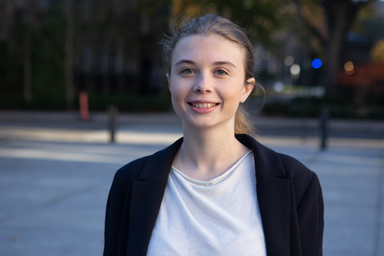

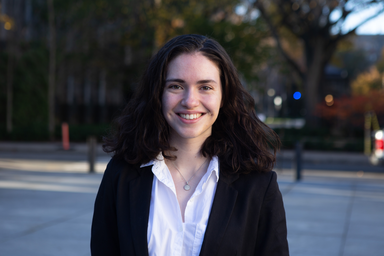

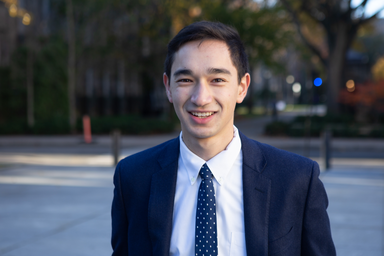

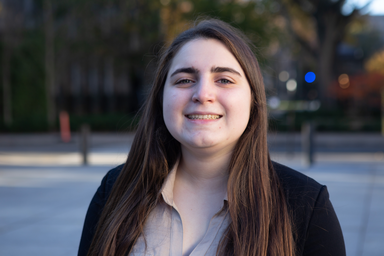

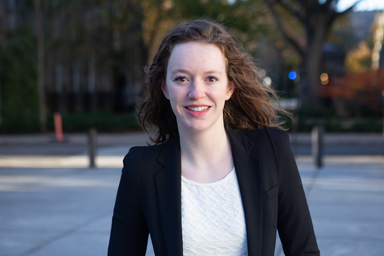

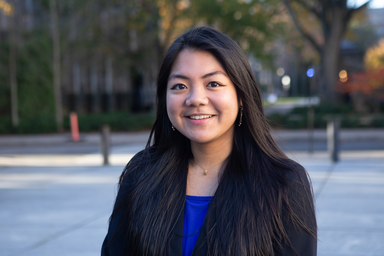

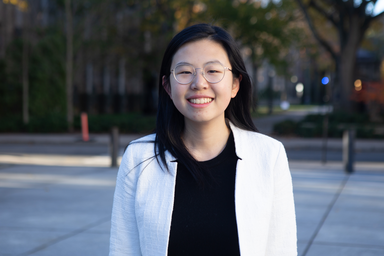

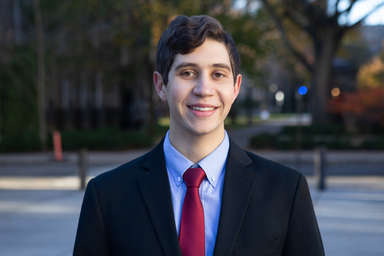

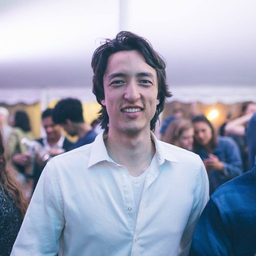

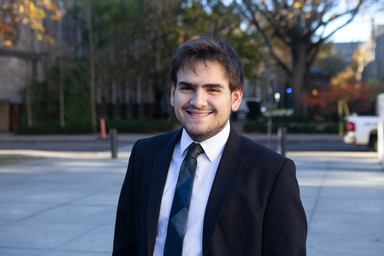

In [5]:
#@title `Get all raw images`
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

In [6]:
#@title `Selecting Tensorflow 1.x`
import tensorflow as tf
print(tf.__version__)

/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/pyt

1.12.2


In [14]:
#@title `Auto-Aligning Faces`
# Look for faces in the images
# Crop out the faces from the images
# Align the faces (center the nose and make the eyes horizontal)
# Rescale the resulting images and save them in "aligned_images" folder

!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anac

In [ ]:
#@title `Checking Newly Aligned Photos`

def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

In [9]:
# #@title `Encoding faces into StyleGAN Latent Space`
# print('Download a pretrained resnet encoder...')
# # model takes an image as input and estimates the corresponding latent code
# !gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
# !mkdir data
# !mv finetuned_resnet.h5 data
# !rm -rf generated_images latent_representations

In [10]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 2 images ready for encoding!
Recommended batch_size for the encode_images process: 2


In [20]:
FAST=False

if FAST:
  print("\n************ Start FAST Latent code optimization process ***************")
  !python encode_images.py \
            --optimizer=lbfgs \
            --face_mask=True \
            --iterations=6 \
            --use_lpips_loss=0 \
            --use_discriminator_loss=0 \
            --output_video=True \
            aligned_images/ \
            generated_images/ \
            latent_representations/
else:
  print("\n************ Start SLOW Latent code optimization process ***************")
  !python encode_images.py \
            --optimizer=adam \
            --lr=0.001 \
            --decay_rate=0.97 \
            --decay_steps=7 \
            --use_l1_penalty=0.3 \
            --face_mask=True \
            --iterations=1 \
            --early_stopping=True \
            --early_stopping_threshold=0.005 \
            --average_best_loss=0.5 \
            --use_lpips_loss=0 \
            --use_discriminator_loss=0 \
            --output_video=True \
            aligned_images/ \
            generated_images/ \
            latent_representations/ 

print("\n************ Latent code optimization finished! ***************")


************ Start SLOW Latent code optimization process ***************
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

IMG_4742_01: loss 99.6167; lr 0.0007:  82%|###2| 82/100 [00:22<00:02,  6.61it/s]


IMG_4742_01: loss 98.1225; lr 0.0007: 100%|###| 100/100 [00:24<00:00,  6.60it/s]
                                                                                IMG_4742_01  Loss 98.1225
100%|#############################################| 1/1 [01:03<00:00, 63.17s/it]
Images Best Losses: [98.12247]
Total Average of Best losses: 98.12246704101562

************ Latent code optimization finished! ***************


In [ ]:
lrs=(0.001, 0.0001)
decay_rates=(0.97, 0.99)
decay_steps=(7, 9)
iterations=(750, 1500)
i=0
!python align_images.py raw_images/ aligned_images/ --output_size=1024
for iteration in iterations:
    for lr in lrs: 
        for decay_rate in decay_rates:
            for decay_step in decay_steps:
                    i+=1
                    !mkdir -p "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}"
                    !mkdir -p "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/generated_images"
                    !mkdir -p "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/latent_representations"
                    !mkdir -p "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/videos"
                    !echo "Started exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}"
                    !python encode_images.py \
                            --optimizer=adam \
                            --lr="{lr}" \
                            --decay_rate="{decay_rate}" \
                            --decay_steps="{decay_step}" \
                            --use_l1_penalty=0.3 \
                            --face_mask=True \
                            --iterations="{iteration}" \
                            --early_stopping=True \
                            --early_stopping_threshold=0.005 \
                            --average_best_loss=0.5 \
                            --use_lpips_loss=0 \
                            --use_discriminator_loss=0 \
                            --output_video=True \
                            --video_dir="exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/videos" \
                            aligned_images/ \
                            "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/generated_images" \
                            "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/latent_representations" > "exps/exp_{i}_iteration_{iteration}_lr_{lr}_decay_rate_{decay_rate}_decay_step_{decay_step}/output.log"
                    

Started exp_1_iteration_750_lr_0.001_decay_rate_0.97_decay_step_7
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

IMG_4742_01: loss 98.1997; lr 0.0010:  11%|4   | 84/750 [00:22<01:42,  6.50it/s]


IMG_4742_01: loss 94.0124; lr 0.0009:  18%|5  | 132/750 [00:30<01:36,  6.41it/s]


IMG_4742_01: loss 91.0663; lr 0.0009:  24%|7  | 181/750 [00:37<01:27,  6.48it/s]


IMG_4742_01: loss 88.6798; lr 0.0009:  31%|9  | 229/750 [00:44<01:19,  6.54it/s]


IMG_4742_01: loss 86.7142; lr 0.0009:  37%|#1 | 278/750 [00:52<01:13,  6.46it/s]


IMG_4742_01: loss 85.0772; lr 0.0008:  43%|#3 | 326/750 [00:59<01:05,  6.46it/s]


IMG_4742_01: loss 83.7161; lr 0.0008:  50%|#5 | 375/750 [01:07<00:58,  6.45it/s]


IMG_4742_01: loss 82.3799; lr 0.0008:  56%|#6 | 423/750 [01:14<00:50,  6.49it/s]


IMG_4742_01: loss 81.2613; lr 0.0008:  63%|#8 | 472/750 [01:22<00:43,  6.44it/s]


IMG_4742_01: loss 80.3771; lr 0.0008:  69%|## | 520/750 [01:30<00:35,  6.48it/s]


IMG_4742_01: loss 79.6595; lr 0.0007:  76%|##2| 569/750 [01:37<00:28,  6.45it/s]


IMG_4742_01: loss 79.1397; lr 0.0007:  81%|##4| 609/750 [01:43<00:21,  6.50it/s]

In [34]:
#@title `loading StyleGAN network into memory`

import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/60362027561e3cdd18da081cf8f58c2c_karras2019stylegan-ffhq-1024x1024.pkl...
StyleGAN loaded & ready for sampling!


In [35]:
#@title `images viz utils`

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

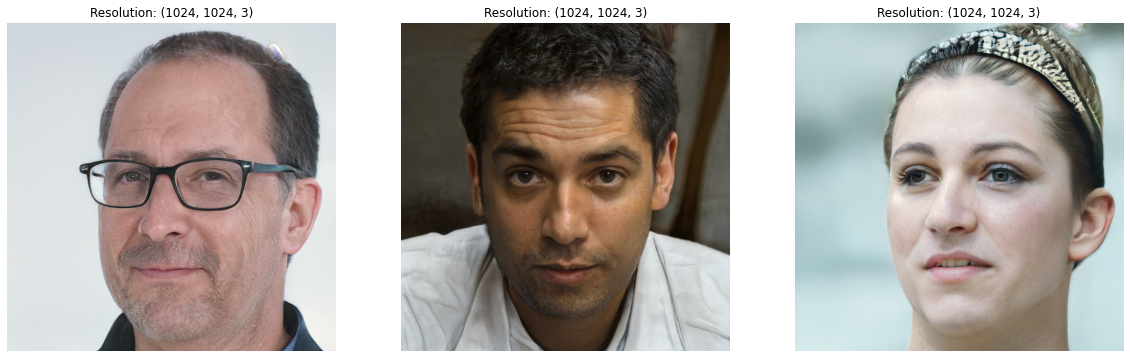

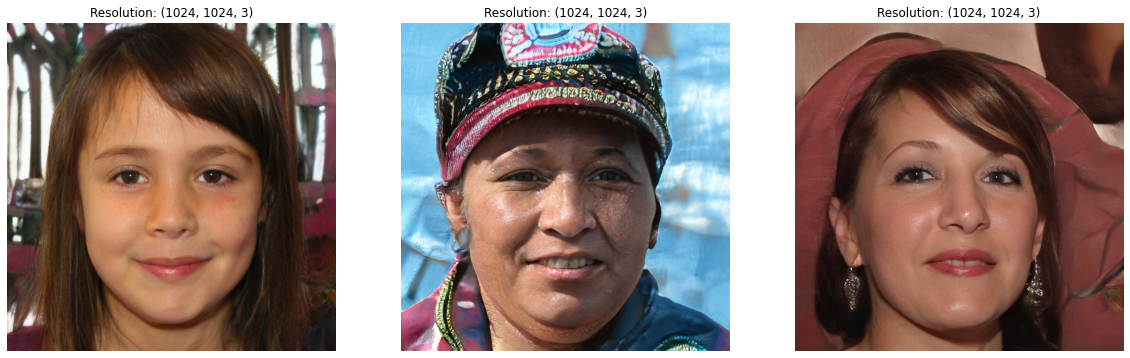

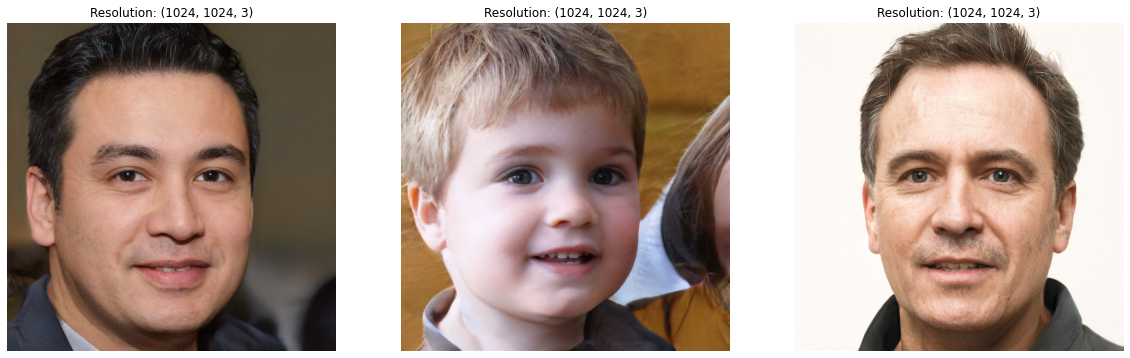

In [36]:
#@title `Plotting random StyleGAN Samples`
#plot_imgs(averaged_generator_network, 3, 3)

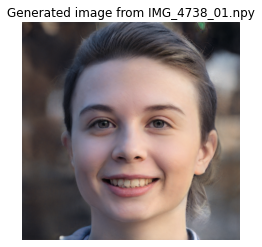

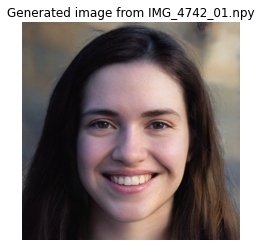

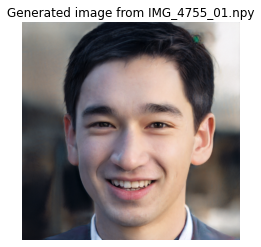

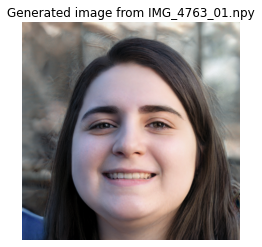

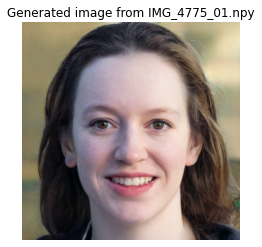

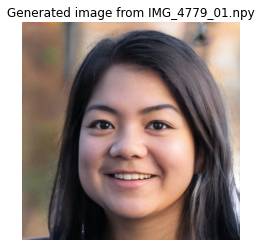

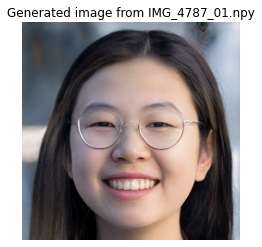

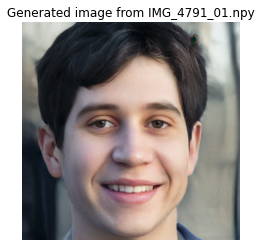

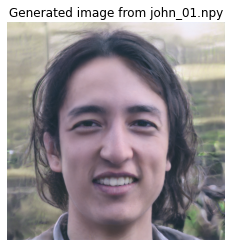

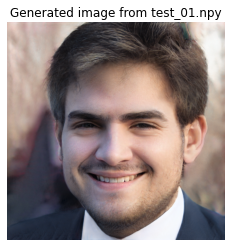

In [97]:
#@title `Results of Encoding`

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

In [99]:
#@title `Compare encoded samples with the original ones`

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
# display_sbs('generated_images/', 'aligned_images/', res = 1024)

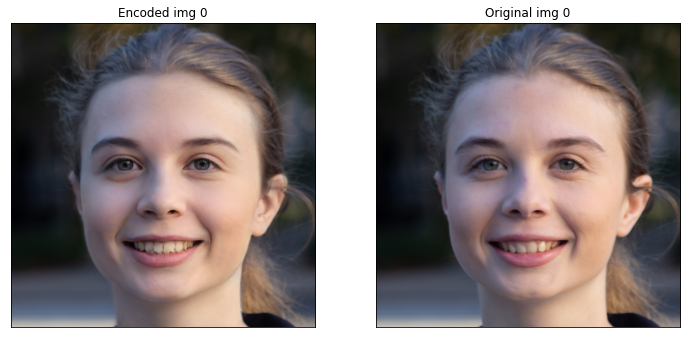

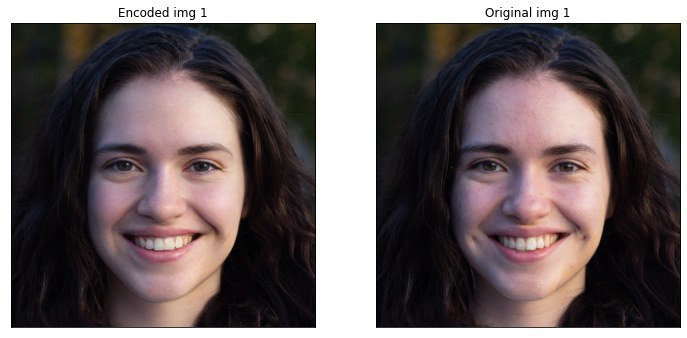

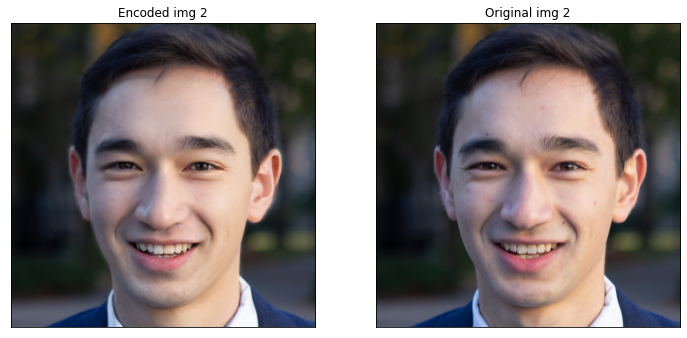

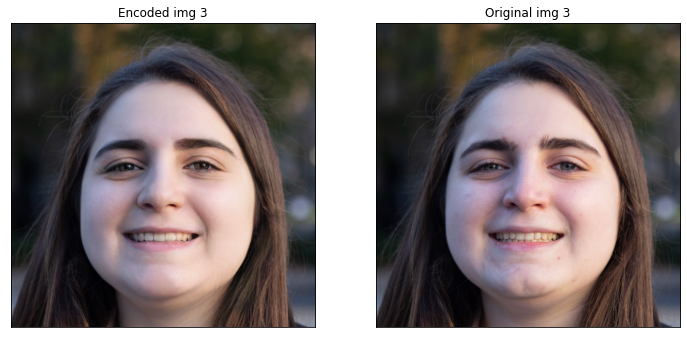

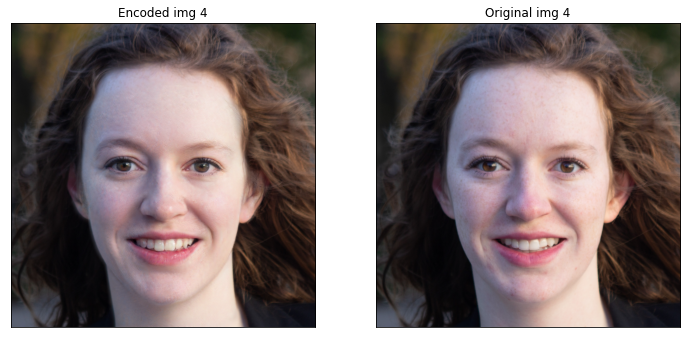

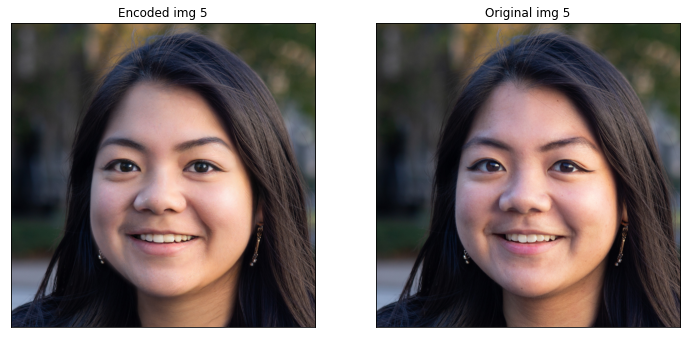

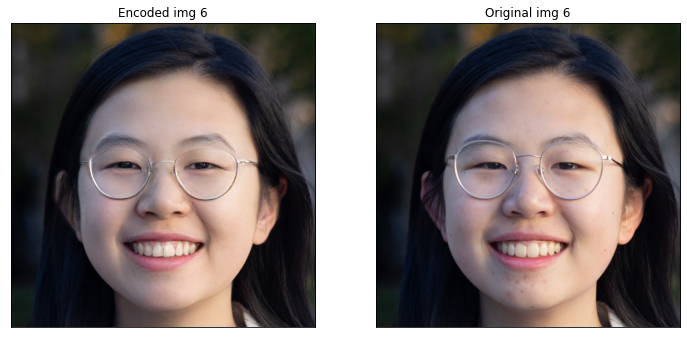

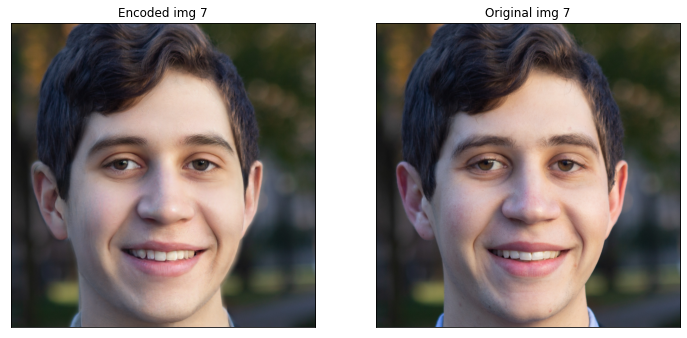

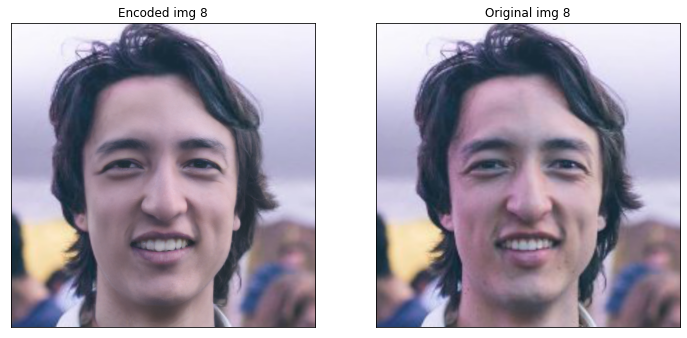

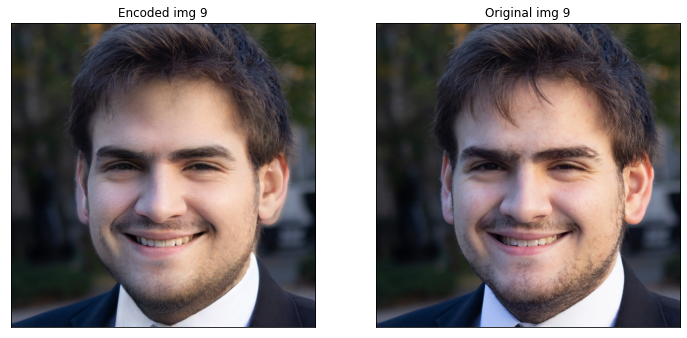

In [98]:
display_sbs('generated_images/', 'aligned_images/', res = 1024)

In [72]:
#@title `Cherry pick images & dump latent vectors to disk`

good_images = [i for i in range(2)] # encoded images numbers

latents = sorted(os.listdir('latent_representations'))

out_file = os.getcwd() + '/latent_vectors/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /home/ubuntu/FaceGAN/stylegan-encoder/latent_vectors/output_vectors.npy!


# Manipulating the faces

In [73]:
#@title `Cloning InterFaceGAN`
%cd ~/FaceGAN
# !git clone https://github.com/AmrMKayid/interfacegan
%cd /home/ubuntu/FaceGAN/interfacegan

/home/ubuntu/FaceGAN
/home/ubuntu/FaceGAN/interfacegan


In [0]:
# #@title `Download the pretrained StyleGAN FFHQ network from NVIDIA`
# !gdown https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
# !mv karras2019stylegan-ffhq-1024x1024.pkl /content/InterFaceGAN/ddkarras2019stylegan-ffhq-1024x1024.pkl

Downloading...
From: https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
To: /content/InterFaceGAN/karras2019stylegan-ffhq-1024x1024.pkl
325MB [00:02, 151MB/s]


In [74]:
#@title `Load Our custom latent space vectors`

final_w_vectors = np.load('/home/ubuntu/FaceGAN/stylegan-encoder/latent_vectors/output_vectors.npy')

print("%d latent vectors of shape %s loaded from %s!" %(final_w_vectors.shape[0], str(final_w_vectors.shape[1:]), 'output_vectors.npy'))

2 latent vectors of shape (18, 512) loaded from output_vectors.npy!


In [75]:
#@title `Boundaries`

# Some Attr Boundaries (-b argument)
# Boundaries: https://github.com/ShenYujun/InterFaceGAN/tree/master/boundaries

# stylegan_ffhq_age_w_boundary.npy
# stylegan_ffhq_eyeglasses_w_boundary.npy
# stylegan_ffhq_gender_w_boundary.npy
# stylegan_ffhq_pose_w_boundary.npy
# stylegan_ffhq_smile_w_boundary.npy

In [76]:
#@title `Latent Space Configs`

latent_direction = 'age'      #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile'] {allow-input: true}

# Controls how strongly we push the face into a certain latent direction (try 1-5)
morph_strength = 3           #@param {type:"slider", min:0, max:5, step:1} 

# The amount of intermediate steps/frames to render along the interpolation path
nr_interpolation_steps = 48  #@param {type:"slider", min:0, max:100, step:1} 

In [77]:
boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction

print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** age ** direction!
Interpolation from -3 to 3 with 48 intermediate frames.

Loading latent directions from stylegan_ffhq_age_w_boundary.npy


In [55]:
#@title `Running latent interpolations`
import subprocess
return_code = subprocess.call("rm -r results/%s" %latent_direction, shell=True)

run_command = "python edit.py \
      -m stylegan_ffhq \
      -b boundaries/stylegan_ffhq_%s_w_boundary.npy \
      -s Wp \
      -i '/content/output_vectors.npy' \
      -o results/%s \
      --start_distance %.2f \
      --end_distance %.2f \
      --steps=%d" %(latent_direction, latent_direction, -morph_strength, morph_strength, nr_interpolation_steps)


print("Running latent interpolations... This should not take longer than ~1 minute")
print("Running: %s" %run_command)
return_code = subprocess.call(run_command, shell=True)

if not return_code:
  print("Latent interpolation successfully dumped to disk!")
else:
  print("Something went wrong, try re-executing this cell...")

Running latent interpolations... This should not take longer than ~1 minute
Running: python edit.py       -m stylegan_ffhq       -b boundaries/stylegan_ffhq_age_w_boundary.npy       -s Wp       -i '/content/output_vectors.npy'       -o results/age       --start_distance -3.00       --end_distance 3.00       --steps=48
Something went wrong, try re-executing this cell...


In [82]:
!rm -rf results/age

In [83]:
!python edit.py       \
        -m stylegan_ffhq       \
        -b boundaries/stylegan_ffhq_age_w_boundary.npy       \
        -s Wp      \
        -i '/content/output_vectors.npy'      \
        -o results/age      \
        --start_distance -3.00      \
        --end_distance 3.00     \
        --steps=48

[2020-06-14 18:52:26,926][INFO] Initializing generator.
[2020-06-14 18:52:27,208][WARNING] No pre-trained model will be loaded!
Traceback (most recent call last):
  File "edit.py", line 118, in <module>
    main()
  File "edit.py", line 72, in main
    model = StyleGANGenerator(args.model_name, logger)
  File "/home/ubuntu/FaceGAN/interfacegan/models/stylegan_generator.py", line 42, in __init__
    super().__init__(model_name, logger)
  File "/home/ubuntu/FaceGAN/interfacegan/models/base_generator.py", line 103, in __init__
    self.model.eval().to(self.run_device)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 443, in to
    return self._apply(convert)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 203, in _apply
    module._apply(fn)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 203, in _apply
    module._app

In [0]:
#@title `Results into movies`

image_folder = '/content/InterFaceGAN/results/%s' %latent_direction
video_fps = 12.

from moviepy.editor import *
import cv2

out_path = '/content/output_videos/'

images = [img_path for img_path in sorted(os.listdir(image_folder)) if '.jpg' in img_path]
os.makedirs(out_path, exist_ok=True)

prev_id = None
img_sets = []
for img_path in images:
  img_id = img_path.split('_')[0]
  if img_id == prev_id: #append
    img_sets[-1].append(img_path)
    
  else: #start a new img set
    img_sets.append([])
    img_sets[-1].append(img_path)
  prev_id = img_id

print("Found %d image sets!\n" %len(img_sets))
if image_folder[-1] != '/':
  image_folder += '/'

def make_video(images, vid_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(vid_name, fourcc, video_fps, (1024, 1024))
    gen = {}
    for img in images:
      video.write(img)
    video.release()
    print('finished '+ vid_name)
    
    
for i in range(len(img_sets)):
  print("############################")
  print("\nGenerating video %d..." %i)
  set_images = []
  vid_name = out_path + 'out_video_%s_%02d.mp4' %(latent_direction,i)
  for img_path in img_sets[i]:
    set_images.append(cv2.imread(image_folder + img_path))

  set_images.extend(reversed(set_images))
  make_video(set_images, vid_name)

In [0]:
#@title `Visualise resulting videos inside Notebook`

video_file_to_show = 0 #@param {type:"slider", min:0, max:5, step:1} 

clip = VideoFileClip(
    '/content/output_videos/out_video_%s_%02d.mp4' %
    (latent_direction, video_file_to_show),)
clip.ipython_display(
    height=512,
    autoplay=1,
    loop=1,
)